# CHARIS MCMC

To speed things up, we used instruments_jax.py instead of instruments.py. Instruments.py should also work in principle, but it has not been tested with MCMC. 

In [1]:
import multiprocessing as mp
import os
mp.set_start_method("spawn", force=True) # Jax was slowing down from os.fork() and this fixed it
os.environ["JAX_PLATFORM_NAME"] = "cpu" # Jax wasn't working with our GPU for unknown reasons
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
import re
import instruments as inst
from instruments_jax import *
from physical_models import *
from scipy import stats as scipy_stats
import h5py
import corner
import shutil
import tqdm
import json

First, I'm going to read the CSVs for all wavelength bins at once so we can do a global fit. 

In [3]:
# test new read func
csv_dir = Path('datacsvs/csvs_nopickoff')
interleaved_values_all, interleaved_stds_all, configuration_list_all = inst.read_csv_physical_model_all_bins(csv_dir)
print(configuration_list_all)

[{'hwp': {'theta': 0.0, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 11.25, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 22.5, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 33.75, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 45.0, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 56.25, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 67.5, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 78.75, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 90.0, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp'

Now, I'm going to set everything up for MCMC. This is my second run; the first time I set my offset bounds to be to small. 

In [5]:
# define CHARIS wavelength bins
wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])

# Getting the system dictionary setup and defining starting guesses values
wavelength_bin = 15 # placeholder
epsilon_cal = 1 # defining as perfect, reasoning in Joost t Hart 2021
offset_imr = -0.01062 
offset_hwp = -0.0022 
offset_cal = -0.0315 
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits from scipy minimize on the naive fits
d = 259.7 
wsio2 = 1.617
wmgf2 = 1.264

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
    "wollaston" : {
        "type" : "wollaston_prism_function",
        "properties" : {"beam": 'o'}, 
        "tag": "internal",
    },
    "image_rotator" : {
        "type" : "SCExAO_IMR_function",
        "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": d, "theta": imr_theta, "delta_theta": offset_imr},
        "tag": "internal",
    },
    "hwp" : {
        "type" : "two_layer_HWP_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
        "tag": "internal",
    },
    "lp" : {  # calibration polarizer for internal calibration source
        "type": "diattenuator_retarder_function",
        "properties": {"epsilon": epsilon_cal, "delta_theta": offset_cal },
        "tag": "internal",
    }}
}
    
# Starting guesses

p0_dict = {
    "image_rotator" : 
        {"d": d, "delta_theta": offset_imr},
    "hwp" :  
        {"w_SiO2": wsio2, "w_MgF2": wmgf2, "delta_theta": offset_hwp},
    "lp" : 
        {"delta_theta": offset_cal},
}

system_mm = inst.generate_system_mueller_matrix(system_dict) # Generating pyMuellerMat system MM

p0 = [1.623, 1.268, 262.56] # Starting guesses from Joost t Hart 2021 
offset_bounds = (-5.0,5.0) # Wider bounds than first MCMC run, offsets were converging to their bounds at first
d_bounds = (0.8*p0[2], 1.2*p0[2]) # Physical parameters shouldn't have changed much
imr_offset_bounds = offset_bounds
wsio2_bounds = (0.8*p0[0], 1.2*p0[0])
wmgf2_bounds = (0.8*p0[1], 1.2*p0[1])
hwp_offset_bounds = offset_bounds
cal_offset_bounds = offset_bounds

bounds = {
    "image_rotator" : 
        {"d": d_bounds, "delta_theta": imr_offset_bounds},
    "hwp" :  
        {"w_SiO2": wsio2_bounds, "w_MgF2": wmgf2_bounds, "delta_theta": hwp_offset_bounds},
    "lp" : 
        {"delta_theta": cal_offset_bounds},
}

# Defining uniform priors

offset_prior = partial(mcmc.uniform_prior, low=-5.0, high=5.0)
d_prior = partial(mcmc.uniform_prior, low=0.7*p0[2], high=1.3 * p0[2])
imr_offset_prior = offset_prior
wsio2_prior = partial(mcmc.uniform_prior, low=0.7*p0[0], high=1.3 * p0[0])
wmgf2_prior = partial(mcmc.uniform_prior, low=0.7*p0[1], high=1.3 * p0[1])
hwp_offset_prior = offset_prior
cal_offset_prior = offset_prior


prior_dict = {
    "image_rotator": {
        "d": {"type": "uniform", "kwargs": {"low":0.8*p0[2], "high": 1.2 * p0[2]}},
        "delta_theta": {"type": "uniform", "kwargs": {"low": -5, "high": 5}},
    },
    "hwp": {
        "w_SiO2": {"type": "uniform", "kwargs": {"low": 0.8*p0[0], "high": 1.2 * p0[0]}},
        "w_MgF2":{"type": "uniform", "kwargs": {"low": 0.8*p0[1], "high": 1.2 * p0[1]}},
        "delta_theta": {"type": "uniform", "kwargs": {"low": -5, "high": 5}},
    },
    "lp": {
        "delta_theta": {"type": "uniform", "kwargs": {"low": -5, "high": 5}},
    },
}

# Storing samples in an h5

output_h5 = Path('mcmc_output_larger_bounds.h5')
with open("mcmcp0.txt", "w") as f:
    json.dump(p0_dict, f, indent=4)

Now I'm going to run the simulation. 

In [6]:
# Interactive plotting
%matplotlib notebook 
ndim = 6  # Number of parameters to fit
# Detect computing resources
pool_processes = max(1, os.cpu_count() - 1) # Leaving one free
nwalkers = max(2 * ndim, pool_processes * 2)
if nwalkers % pool_processes != 0:
    nwalkers += pool_processes - (nwalkers % pool_processes)

print(f"Auto-detected: {pool_processes} processes, {nwalkers} walkers for {ndim} parameters")
sampler, p_keys = run_mcmc(p0_dict, system_mm, interleaved_values_all, interleaved_stds_all,configuration_list_all,prior_dict,bounds,logl_with_logf, output_h5,nwalkers=14, include_log_f=True, log_f=-3.0, pool_processes=pool_processes,process_model=process_model, nsteps=40000,plot=True, mode='CHARIS')

Auto-detected: 7 processes, 14 walkers for 6 parameters


<IPython.core.display.Javascript object>

  0%|          | 18/40000 [00:23<14:26:38,  1.30s/it]


KeyboardInterrupt: 

In [16]:
def plot_corner_flat(chain, param_names, step_range=(0, None), median_or_max="median", num_bins=100):
    flat_chain = chain[step_range[0]:step_range[1], :, :].reshape(-1, chain.shape[-1])
    converted_chain = flat_chain.copy()

    for i, name in enumerate(param_names):
        if ".phi" in name:
            converted_chain[:, i] = converted_chain[:, i] / (2 * np.pi)

    if median_or_max == "median":
        truths = np.median(converted_chain, axis=0)
    elif median_or_max == "max":
        truths = []
        for i in range(converted_chain.shape[1]):
            hist, bin_edges = np.histogram(converted_chain[:, i], bins=num_bins)
            max_index = np.argmax(hist)
            max_val = (bin_edges[max_index] + bin_edges[max_index + 1]) / 2
            truths.append(max_val)
        truths = np.array(truths)
    else:
        raise ValueError("median_or_max must be 'median' or 'max'")
 
    fig = corner.corner(
        converted_chain,
        labels = [name.replace("delta_theta", "offset").replace("image_rotator", "imr") for name in param_names],
        truths=truths,
        plot_datapoints=False, label_kwargs={"fontsize":3}   # disables individual scatter points
    )

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.xaxis.labelpad = 40
        ax.yaxis.labelpad = 40

    plt.tick_params(axis='x', which='both', pad=5)
    plt.tick_params(axis='y', which='both', pad=5)
    return fig

def load_chain_and_labels(h5_filename, txt_filename, include_logf=False):
    base, ext = os.path.splitext(h5_filename)
    h5_copy = base + "_copy" + ext
    shutil.copy(h5_filename, h5_copy)

    with h5py.File(h5_copy, 'r') as f:
        chain = f['mcmc']['chain'][:]

    with open(txt_filename, 'r') as f:
        p0_dict = json.load(f)

    param_names = [f"{comp}.{param}" for comp, params in p0_dict.items() for param in params]
    if include_logf:
        param_names.append("log_f")

    return chain, param_names

(40000, 14, 7)


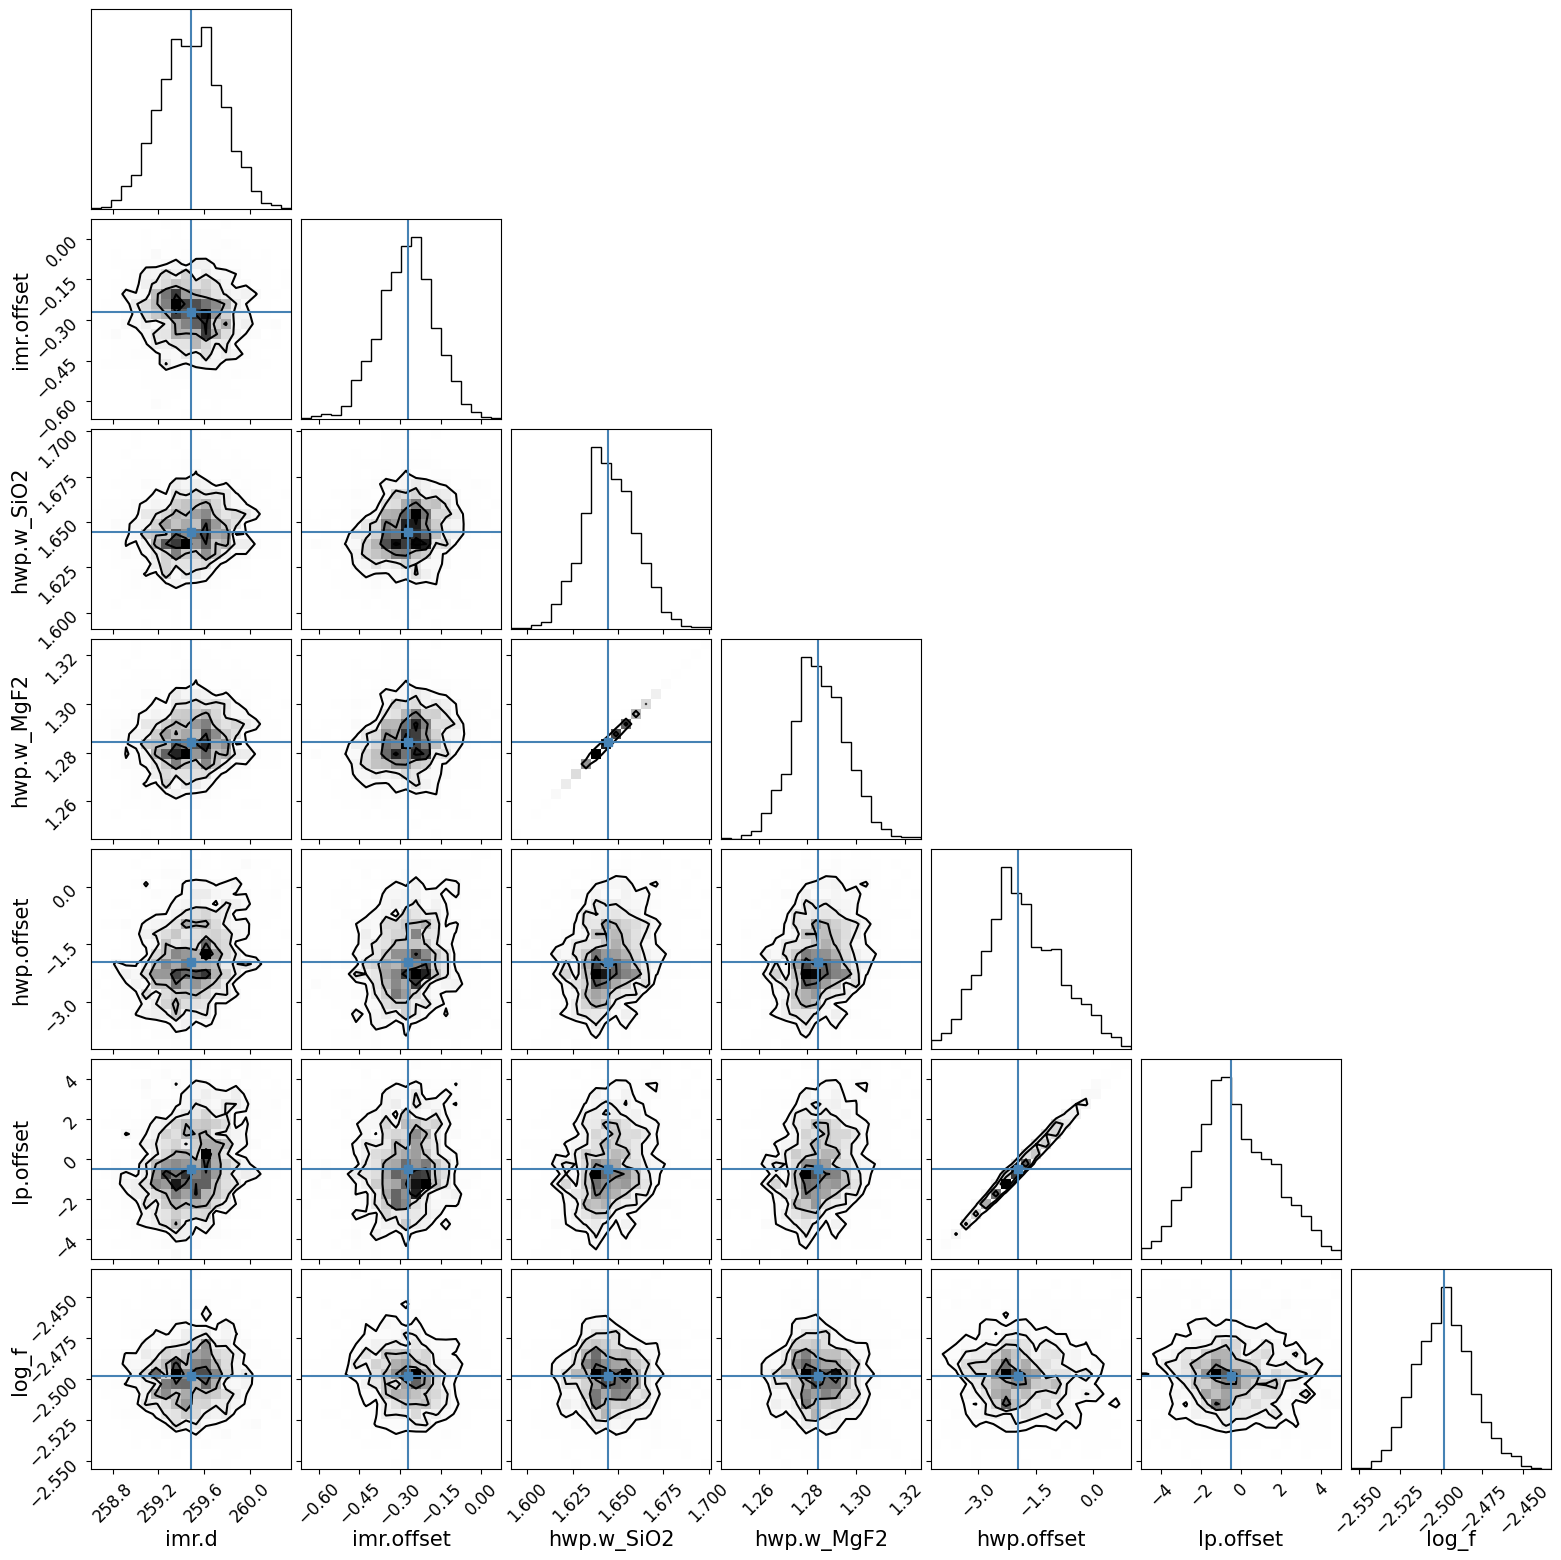

In [18]:
json_filepath = 'mcmcp0.json'
output_h5 = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/mcmc_output_larger_bounds.h5'
chain, names = load_chain_and_labels(output_h5, json_filepath, include_logf = True)
corner_plot_step_range = (15300,16000)
fig = plot_corner_flat(chain, names, step_range=corner_plot_step_range)
print(chain.shape)
for ax in fig.get_axes():
    if ax.xaxis.label:  # check label exists
        ax.xaxis.label.set_fontsize(15)  # your desired size
    if ax.yaxis.label:
        ax.yaxis.label.set_fontsize(15)


Looks like it converged nicely, but there is a clear degeneracy between the HWP offset and the LP offset. The degeneracy between the two HWP thicknesses seems reasonable.

In [14]:
print("Shape:", chain.shape)
print("NaNs:", np.isnan(chain).any())
print("Infs:", np.isinf(chain).any())

means = np.mean(chain[:, :, :-1], axis=(0, 1))
stds = np.std(chain[:, :, :-1], axis=(0, 1))
print("Means:", means)
print("Stds :", stds)
for i in range(6):  # skip log(f)
    plt.figure()
    for w in range(14):
        plt.plot(chain[:, w, i], alpha=0.6)
        plt.xlim(0,15900)
    plt.title(f"{names[i]} trace")
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.show()

NameError: name 'chain' is not defined

In [7]:
inst.summarize_median_posterior(output_h5,p0_dict,step_range=(8000,16000))


AttributeError: You must run the sampler with 'store == True' before accessing the results

There seem to be large errors on the hwp and lp offsets. Whatever is causing this degeneracy will require more investigation.

In [2]:
import numpy as np
starts = np.array([1.623,1.268,-0.002,262.56,-0.0118,-0.035])
finishes = np.array([1.645,1.285,-2.097,259.507,-0.27842,-0.791])
differencebetween = np.abs(starts-finishes)/starts
print(differencebetween)



[ 1.35551448e-02  1.34069401e-02 -1.04750000e+03  1.16278184e-02
 -2.25949153e+01 -2.16000000e+01]


In [8]:
def summarize_posteriors(chain, param_names, system_dict, txt_file_path=None, txt_save_file_path=None, step_range=(0, None)):
    import instruments_jax as inst

    # Flatten MCMC chain
    flat_chain = chain[step_range[0]:step_range[1], :, :].reshape(-1, chain.shape[-1])

    # Generate the base system Mueller matrix from a known full system_dict
    system_mm = inst.generate_system_mueller_matrix(system_dict)

    # If provided, use the .txt param dict to get parameter keys
    if txt_file_path is not None:
        with open(txt_file_path, "r") as f:
            param_dict = json.load(f)
        _, p_keys = inst.parse_configuration(param_dict)
    else:
        raise ValueError("You must supply txt_file_path to extract parameter keys.")

    # Compute medians
    new_param_values = []
    for i, name in enumerate(param_names):
        val = flat_chain[:, i] / (2 * np.pi) if ".phi" in name else flat_chain[:, i]
        median = np.median(val)
        std = np.std(val)
        new_param_values.append(median)
        print(f"{name} ({'waves' if '.phi' in name else ''}): {median:.5f} ± {std:.5f}")

    if txt_save_file_path is not None:
        updated_mm = inst.update_system_mm(new_param_values, p_keys, system_mm)
        updated_dict = updated_mm.master_property_dict
        with open(txt_save_file_path, "w") as f:
            json.dump(updated_dict, f, indent=4)


In [28]:
summarize_posteriors(chain,names,system_dict,'mcmcp0.txt',step_range=(15000,16000),txt_save_file_path='posteriorsummary.txt')


image_rotator.d (): 259.48497 ± 0.26548
image_rotator.delta_theta (): -0.27592 ± 0.10228
hwp.w_SiO2 (): 1.64462 ± 0.01409
hwp.w_MgF2 (): 1.28446 ± 0.01046
hwp.delta_theta (): -2.06699 ± 0.97853
lp.delta_theta (): -0.71128 ± 1.93599
log_f (): -2.49830 ± 0.01713


In [50]:
with open("posteriorsummary.txt", "r") as f:
    p0_new = json.load(f)
#p0vals,pnames = parse_configuration(p0_new)
p0vals1,pnames1 = parse_configuration(p0_dict)
#lf = -2.49830
lf1 = -3
#p0vals.append(lf)
p0vals1.append(lf1)
logl_with_logf(p0vals1,system_mm,interleaved_values_all,interleaved_stds_all,configuration_list_all,pnames1,[1,0,0,0],process_model=process_model,mode='CHARIS',process_dataset=None,process_errors=None)

Array(-571551.6, dtype=float32)